In [1]:
# Read labels
import utils
Wiki_class_labels = "/home/infres/ypeng-21/work/Taxon_clean/build_dataset/test/build_data_from_nt/24_03_22/raw_data/wikidata_src/wiki_taxonomy_labels.tsv"
cls2label = utils.load_label(Wiki_class_labels)

/home/infres/ypeng-21/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read a graph from a file
import os
from collections import defaultdict
from sknetwork.data import from_adjacency_list
path = './data/graph/'
graph_file = 'clean_wikiTaxonUp0.tsv'

wikidown = defaultdict(list)
with open(os.path.join(path, graph_file), 'r') as taxon:
    for line in taxon:
        child, parent = line.strip().split('\t')
        wikidown[parent].append(child)

wikigraph = from_adjacency_list(wikidown, directed=True)

In [3]:
from sknetwork.embedding import ForceAtlas, Spring
from sknetwork.path import get_distances, breadth_first_search
from sknetwork.visualization import svg_graph
from IPython.display import SVG
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix

adjacency = wikigraph['adjacency']
names = list(wikigraph['names'])

start_index = names.index('wd:Q35120') # entity
end_index = names.index('wd:Q7930989') # target node

adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart = adjacency_transpose[ancestors, :][:, ancestors]
exart_nodes = list(np.array(names)[ancestors])

# exart
entity_index = exart_nodes.index('wd:Q35120')
distances = get_distances(exart.T, source=entity_index)
max_dist = max(distances)
inv_distances = [-x+max_dist-1 for x in distances]
weights = np.clip(inv_distances, a_min=0, a_max=10)
name_labels = [cls2label[qid] for qid in exart_nodes]

In [4]:
name_labels

['city or town',
 'urban settlement',
 'locality',
 'urban area',
 'human settlement',
 'section of populated place',
 'part (piece)',
 'populated place',
 'geographic region',
 'region of space',
 'artificial geographic entity',
 'entity',
 'spacetime region',
 'artificial object',
 'spatial entity',
 'geographic entity',
 'continuant',
 'spatio-temporal entity',
 'object',
 'mathematical object',
 'abstract entity']

In [5]:
ori_nodes = ['wd:Q7930989',
 'wd:Q124250988',
 'wd:Q3257686',
 'wd:Q702492',
 'wd:Q486972',
 'wd:Q48907157',
 'wd:Q15989253',
 'wd:Q123964505',
 'wd:Q82794',
 'wd:Q26713767',
 'wd:Q27096235',
 'wd:Q35120',
 'wd:Q23956024',
 'wd:Q16686448',
 'wd:Q58416391',
 'wd:Q27096213',
 'wd:Q103940464',
 'wd:Q58415929',
 'wd:Q488383',
 'wd:Q246672',
 'wd:Q7048977']

In [6]:
ori_position = np.array([[ 0.50724006, -1.50546935],
       [ 0.17339569, -1.40830145],
       [ 0.65318635, -1.16166466],
       [-0.07333105, -1.10416012],
       [ 0.24395499, -0.96205877],
       [ 0.82605656, -0.74490163],
       [ 0.939873  , -0.23559766],
       [ 0.11388487, -0.72282675],
       [-0.25911111, -0.64649449],
       [-0.42310854, -0.32413033],
       [ 0.16297914, -0.42190657],
       [ 0.92903534,  0.42853186],
       [-0.17333105,  0.12323218],
       [ 0.18498939,  0.01300668],
       [-0.31534483,  0.24045825],
       [ 0.69995992, -0.07095023],
       [ 0.75337341,  0.21152963],
       [-0.03026624,  0.52404289],
       [ 0.34507941,  0.44022587],
       [-0.00830009,  0.69421331],
       [ 0.39949707,  0.63391492]])

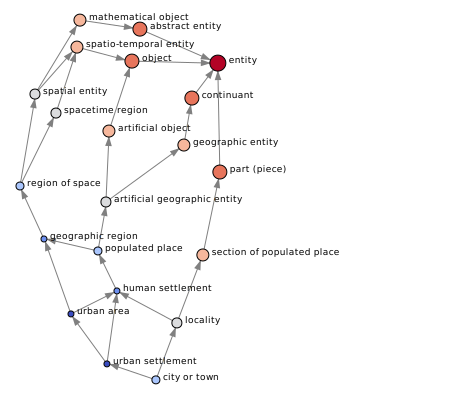

In [7]:
image = svg_graph(exart, position=ori_position, names=name_labels, display_node_weight=True, 
                  node_weights=weights, node_size_max=8, node_size_min=3,
                  scores=-distances, scale=1, font_size=9, height=360, width=200)
SVG(image)

* draw graphs

In [10]:
def load_graph(graph_file):
    wikidown = defaultdict(list)
    with open(os.path.join('./data/graph/', graph_file), 'r') as taxon:
        for line in taxon:
            child, parent = line.strip().split('\t')
            wikidown[parent].append(child)
    wikigraph = from_adjacency_list(wikidown, directed=True)
    return wikigraph

def get_path_exart(graph, target_node):
    adjacency = graph['adjacency']
    names = list(graph['names'])

    start_index = names.index('wd:Q35120') # entity
    end_index = names.index(target_node) # target node
    adjacency_transpose = adjacency.T # subclass_of relation
    ancestors = breadth_first_search(adjacency_transpose, source=end_index)
    exart = adjacency_transpose[ancestors, :][:, ancestors]
    exart_nodes = list(np.array(names)[ancestors])

    # get exart
    entity_index = exart_nodes.index('wd:Q35120')
    distances = get_distances(exart.T, source=entity_index)
    max_dist = max(distances)
    inv_distances = [-x+max_dist-1 for x in distances]
    weights = np.clip(inv_distances, a_min=0, a_max=10)
    name_labels = [cls2label[qid] for qid in exart_nodes]
    return exart, exart_nodes, name_labels, weights, distances


def get_position(ori_nodes, ori_position, new_nodes):
    position = []
    for node in new_nodes:
        index = ori_nodes.index(node)
        position.append(ori_position[index])
    return np.array(position)

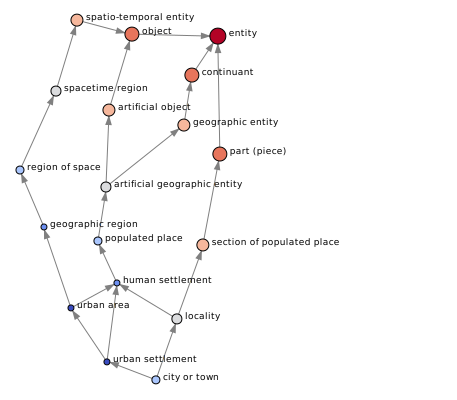

In [11]:
graph = load_graph('clean_wikiTaxonUp2.tsv') # after cutting
exart, exart_nodes, labels, weights, distances = get_path_exart(graph, 'wd:Q7930989')
position = get_position(ori_nodes, ori_position, exart_nodes)

image = svg_graph(exart, position=position, names=labels, display_node_weight=True, 
                  node_weights=weights, node_size_max=8, node_size_min=3,
                  scores=-distances, scale=1, font_size=9, height=360, width=200)
SVG(image)

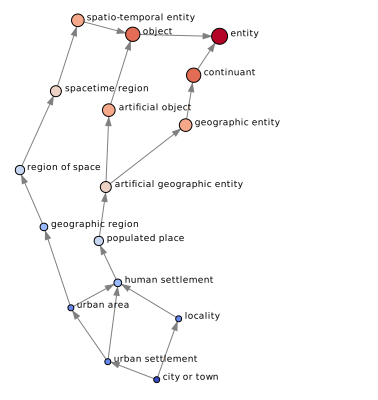

In [12]:
graph = load_graph('clean_wikiTaxonUp3.tsv') # after resovling
exart, exart_nodes, labels, weights, distances = get_path_exart(graph, 'wd:Q7930989')
position = get_position(ori_nodes, ori_position, exart_nodes)

image = svg_graph(exart, position=position, names=labels, display_node_weight=True, 
                  node_weights=weights, node_size_max=8, node_size_min=3,
                  scores=-distances, scale=1, font_size=9, height=360, width=200)
SVG(image)

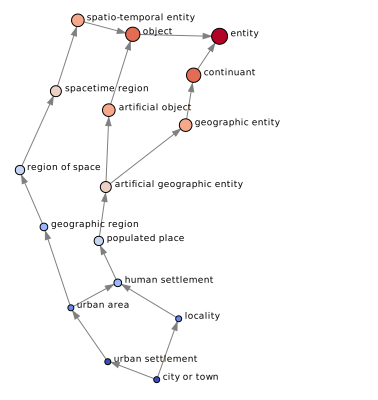

In [13]:
graph = load_graph('clean_wikiTaxonUp4.tsv') # after reducing
exart, exart_nodes, labels, weights, distances = get_path_exart(graph, 'wd:Q7930989')
position = get_position(ori_nodes, ori_position, exart_nodes)

image = svg_graph(exart, position=position, names=labels, display_node_weight=True, 
                  node_weights=weights, node_size_max=8, node_size_min=3,
                  scores=-distances, scale=1, font_size=9, height=360, width=200)
SVG(image)

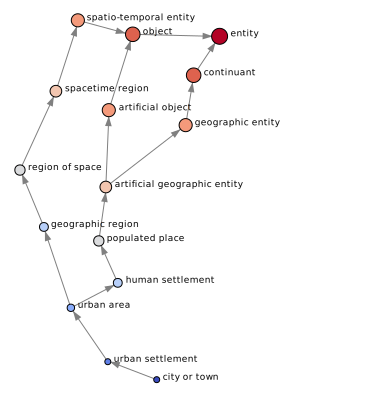

In [193]:
graph = load_graph('clean_wikiTaxonUp8.tsv') # after merging
exart, exart_nodes, labels, weights, distances = get_path_exart(graph, 'wd:Q7930989')
position = get_position(ori_nodes, ori_position, exart_nodes)

image = svg_graph(exart, position=position, names=labels, display_node_weight=True, 
                  node_weights=weights, node_size_max=8, node_size_min=3,
                  scores=-distances, scale=1, font_size=9, height=360, width=200)
SVG(image)

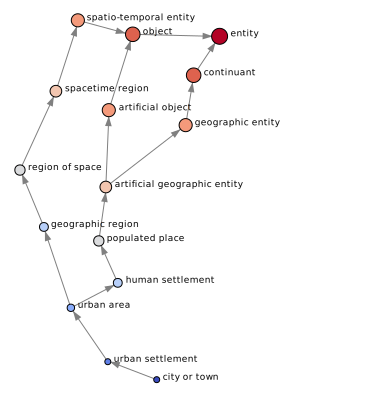

In [14]:
graph = load_graph('clean_wikiTaxonUp5.tsv') # after rewiring
exart, exart_nodes, labels, weights, distances = get_path_exart(graph, 'wd:Q7930989')
position = get_position(ori_nodes, ori_position, exart_nodes)

image = svg_graph(exart, position=position, names=labels, display_node_weight=True, 
                  node_weights=weights, node_size_max=8, node_size_min=3,
                  scores=-distances, scale=1, font_size=9, height=360, width=200)
SVG(image)

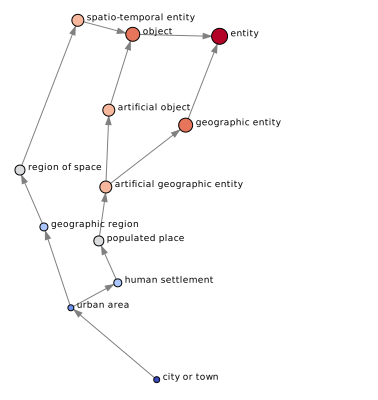

In [15]:
graph = load_graph('clean_wikiTaxonUp.tsv') # after filtering (post-processing)
exart, exart_nodes, labels, weights, distances = get_path_exart(graph, 'wd:Q7930989')
position = get_position(ori_nodes, ori_position, exart_nodes)

image = svg_graph(exart, position=position, names=labels, display_node_weight=True, 
                  node_weights=weights, node_size_max=8, node_size_min=3,
                  scores=-distances, scale=1, font_size=9, height=360, width=200)
SVG(image)

In [125]:
exart_nodes

['wd:Q7930989',
 'wd:Q124250988',
 'wd:Q3257686',
 'wd:Q702492',
 'wd:Q486972',
 'wd:Q48907157',
 'wd:Q15989253',
 'wd:Q123964505',
 'wd:Q82794',
 'wd:Q26713767',
 'wd:Q27096235',
 'wd:Q35120',
 'wd:Q23956024',
 'wd:Q16686448',
 'wd:Q58416391',
 'wd:Q27096213',
 'wd:Q103940464',
 'wd:Q58415929',
 'wd:Q488383',
 'wd:Q246672',
 'wd:Q7048977']

In [126]:
name_labels

['city or town',
 'urban settlement',
 'locality',
 'urban area',
 'human settlement',
 'section of populated place',
 'part (piece)',
 'populated place',
 'geographic region',
 'region of space',
 'artificial geographic entity',
 'entity',
 'spacetime region',
 'artificial object',
 'spatial entity',
 'geographic entity',
 'continuant',
 'spatio-temporal entity',
 'object',
 'mathematical object',
 'abstract entity']

In [123]:
position1

array([[ 0.50724006, -1.50546935],
       [ 0.17339569, -1.40830145],
       [ 0.65318635, -1.16166466],
       [-0.07333105, -1.10516012],
       [ 0.24395499, -1.12605877],
       [ 0.90605656, -0.74490163],
       [ 0.902873  , -0.23559766],
       [ 0.11388487, -0.72282675],
       [-0.25911111, -0.64649449],
       [-0.45810854, -0.11413033],
       [ 0.35297914, -0.32190657],
       [ 0.61903534,  0.26853186],
       [-0.6126407 ,  0.23323218],
       [ 0.22498939,  0.01300668],
       [-0.31534483,  0.32045825],
       [ 0.69995992, -0.07095023],
       [ 0.91337341,  0.21152963],
       [-0.3026624 ,  0.46404289],
       [ 0.16507941,  0.34022587],
       [-0.00830009,  0.67421331],
       [ 0.39949707,  0.65391492]])

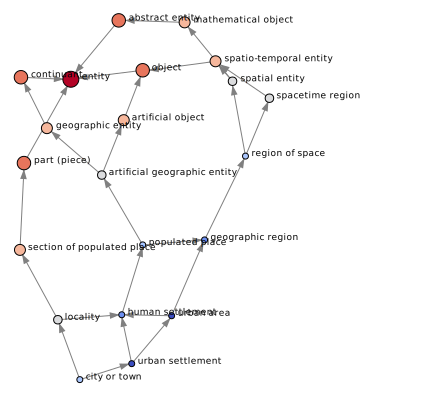

In [122]:
force_atlas = Spring()
position2 = force_atlas.fit_transform(exart)

image = svg_graph(exart, position=position2, names=name_labels, display_node_weight=True, 
                  node_weights=weights, node_size_max=8, node_size_min=3,
                  scores=-distances, scale=1, font_size=9, height=360, width=250)
SVG(image)